# Toy GW detection with SWYFT

In [10]:
import numpy as np
import pylab as plt
import swyft
import torch
from scipy import stats
from tqdm import tqdm
from scipy import fft
%load_ext autoreload
%autoreload 2

np.random.seed(25)
torch.manual_seed(25)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
DEVICE = 'cuda:0'
NDIM = 1 # number of parameters
NBINS = 60 * 4096  # 60 seconds with  4096 Hz resolution
SIGMA = 0.1
DEVICE = 'cuda'

In [18]:
# A toy model with a diffuse and point source component


def model(z):
    t = torch.linspace(0, 60, NBINS).to(DEVICE)
    t0 = np.random.uniform(40, 50)
    f0 =  np.random.uniform(0.5, 1.0)
    phase = np.random.uniform(0, 2*np.pi)
    
    #t0 = 45
    #f0 = 1.
    #phase = 0.
    
    freq = t/t0 * f0
    A = t/t0/(1+(t/t0)**100)
    mu = A*torch.sin(t*2*np.pi*freq + phase)
    
    SNR = ((mu**2)/SIGMA**2).sum()**0.5
    
    x = mu/SNR*z[0]*10
    n = torch.randn(*mu.shape, device = DEVICE)*SIGMA
    
    x += n  # Comment out to remove noise
    x = x.cpu().numpy()
    
    return x

In [19]:
def model_f(z):
    x = model(z)
    xf = fft.fft(x)
    xf = np.hstack([xf[0:200], xf[-200:]])  # other frequencies don't matter (visually, checked without noise)
    #xA = (np.real(xf)**2 + np.imag(xf)**2)**0.5
    xI = np.imag(xf) + 1e-10
    xR = np.real(xf) + 1e-10
    x = np.hstack([xR, xI])
    return x

Text(0.5, 0, 'Frequency channels')

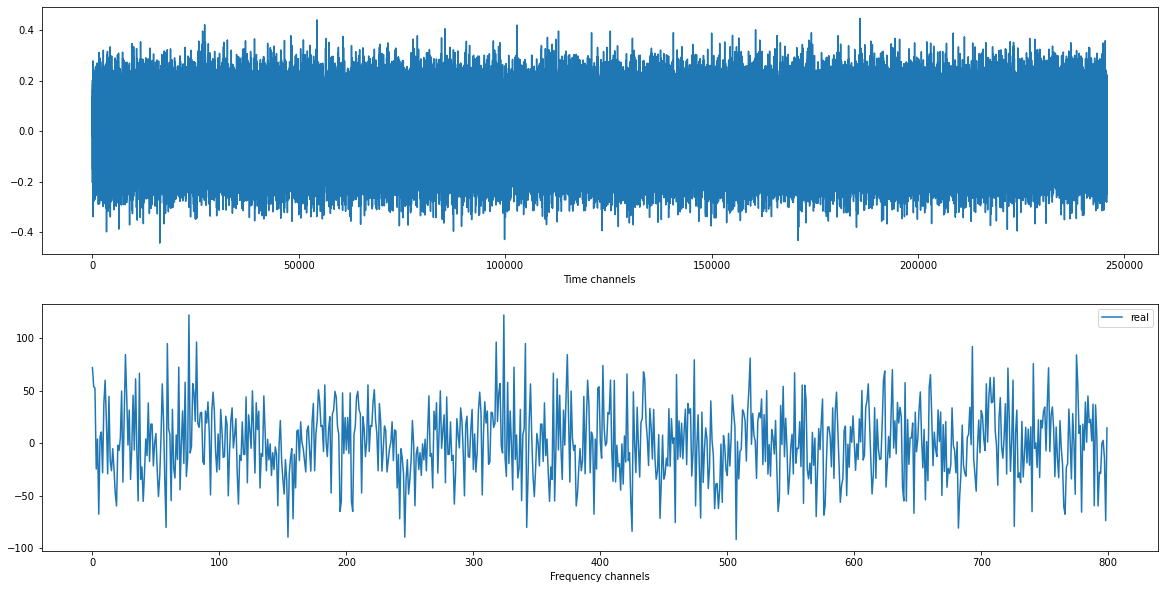

In [20]:
z0 = np.array([.5])  # Parameter corresponds to classical SNR/10 = z[0], 0.5 is 5 sigma (if all parameters were fixed)
x0 = model(z0)
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(x0)
plt.xlabel("Time channels")

plt.subplot(212)
xF = model_f(z0)
plt.plot(xF, label='real')
#plt.plot(xF[1], label='imag')
plt.legend()
plt.xlabel("Frequency channels")

In [287]:
# Convolutional network as HEAD of inference network

class Head(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv1d(1, 10, 5)
        self.conv2 = torch.nn.Conv1d(10, 20, 5)
        self.conv3 = torch.nn.Conv1d(20, 40, 5)
        self.conv4 = torch.nn.Conv1d(40, 80, 5)
        self.pool = torch.nn.MaxPool1d(3)

    def forward(self, x):
        nbatch = len(x)
        #print(x.shape)

        x = x.unsqueeze(1)

        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = self.conv4(x)
        x = self.pool(x)
        x = x.view(nbatch, -1)

        return x


# Convolutional network as HEAD of inference network

class HeadLinear(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = torch.nn.Linear(800, 32)
        
    def forward(self, x):
        return self.lin(x)


# Convolutional network as HEAD of inference network

class HeadFlat(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv1d(1, 1, 5)
        self.pool = torch.nn.MaxPool1d(250)
        
    def forward(self, x):
        nbatch = len(x)
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.pool(x)
        x = x.view(nbatch, -1)
        
        return x

In [297]:
# Instantiate network

sw = swyft.SWYFT(xF, model_f, zdim = NDIM, device = DEVICE, head = Head)
sw.run(nrounds = 1, max_epochs = 100, early_stopping_patience = 2, recycle_net = False, nsamples = 20000, nbatch = 16)

Adding samples.: 100%|██████████| 19953/19953 [00:00<00:00, 35862.55it/s]


Adding 19953 new samples.


Adding simulations: 100%|██████████| 19953/19953 [00:00<00:00, 27258.41it/s]


Number of output features: 560
Start training
LR iteration 0
Total epochs: 4
Validation losses: [2.0488264113664627, 2.0465831868350506, 2.108905464410782, 2.175243427976966]
LR iteration 1
Total epochs: 3
Validation losses: [2.0986569672822952, 2.1375120133161545, 2.1977957040071487]
LR iteration 2
Total epochs: 3
Validation losses: [2.085516434162855, 2.086547527462244, 2.089345123618841]


1.5085082122806772 3.040937366932325
Significance: 2.0966849182660647
19953


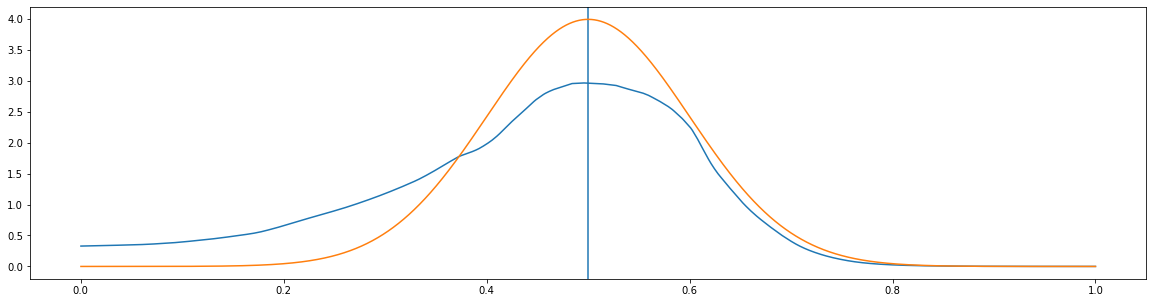

In [306]:
z0 = np.array([.5])
xF = model_f(z0)

plt.figure(figsize=(20, 5))
for i in range(1):
    z, p = sw.posterior(i, version = -1, x0 = xF)
    err68 = swyft.get_stats(z, p)['err68']
    err95 = swyft.get_stats(z, p)['err95']
    print(err68/0.1, err95/0.1)
    plt.axvline(z0[0])
    TS = 2*np.log((p.max()/p[0]).numpy())
    print("Significance:", TS**0.5)
    plt.plot(z, p)
    print(len(z))
    plt.plot(z, stats.norm.pdf(z, 0.5, 0.1))
#plt.gca().set_yscale('log')

We estimate the marginal likelihood ratio
$$
\ln L_m / L_0
$$
since
$$
r(x, z) = \frac{\int d\eta\, p(x|z, \eta)p(\eta)}{p(x)}
$$

In [381]:
TS_list = []
for i in tqdm(range(300)):
    z0 = np.array([.0])
    x0 = model(z0)
    z, p = sw.posterior(0, version = -1, x0 = x0)
    TS = 2*np.log((p.max()/p[0]).numpy())
    TS_list.append(TS)

100%|██████████| 300/300 [05:32<00:00,  1.11s/it]


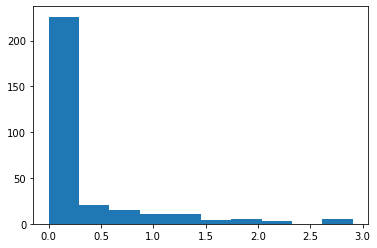

In [383]:
plt.hist(np.array(TS_list)**0.5);